# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Семинар 03. Обучений нейросетей на PyTorch`

### `Материалы составили Оганов Александр (@welmud), Находнов Максим (nakhodnov17@gmail.com)`

#### `Москва, Весенний семестр 2025`

Цель ноутбука познакомить с некоторыми аспекты обучения нейросетей с помощью библиотеки PyTorch. Эксперименты проводятся на датасете **[Imagenette](https://github.com/fastai/imagenette.git)**. 

Официальные туториалы PyTorch по этим темам:

* [Neural networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) - сборка простейшей нейронной сети,

* [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) - обучение классификатора на **Cifar10**,

* [Reproducibilty PyTorch](https://pytorch.org/docs/stable/notes/randomness.html) - как обучать нейросети воспроизводимо,

* [Training recipe](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/) - подробное описание получения SOTA результатов.

Посмотреть логи `wandb` всех запусков [можно тут](https://wandb.ai/3145tttt/cnn_mmp_2025/overview).

In [1]:
%config Completer.use_jedi = False # чтобы автодополнение с помощью табов работало
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder

import matplotlib_inline
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

### `Данные`

`Imagenette` является подмножеством, из 10 самых легко классифицируемых классов, датасета `Imagenet`. Мы могли бы воспользовать удобной оберткой `torchvision.datasets.Imagenette`, но наша цель **научиться обучать модели от начала до конца**. Начнем с определение датасета и даталоадеров.


[Страница Imagenette на PyTorch](https://pytorch.org/vision/stable/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette)

[Официальный GitHub](https://github.com/fastai/imagenette#imagenette-1)

In [4]:
DATA_DIR = "./imagenette2-160/"

if not os.path.exists(DATA_DIR): 
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
    !tar -xf ./imagenette2-160.tgz
    
os.listdir(DATA_DIR)

['train', 'noisy_imagenette.csv', '.DS_Store', 'val']

In [5]:
data_df_path = os.path.join(DATA_DIR, 'noisy_imagenette.csv')

data_df = pd.read_csv(data_df_path)
data_df.head()

path noisy_labels_0 noisy_labels_1  \
0           train/n02979186/n02979186_9036.JPEG      n02979186      n02979186   
1          train/n02979186/n02979186_11957.JPEG      n02979186      n02979186   
2           train/n02979186/n02979186_9715.JPEG      n02979186      n02979186   
3          train/n02979186/n02979186_21736.JPEG      n02979186      n02979186   
4  train/n02979186/ILSVRC2012_val_00046953.JPEG      n02979186      n02979186   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  
0      n02979186       n02979186       n02979186     False  
1      n02979186       n02979186       n03000684     False  
2      n02979186       n03417042       n03000684     False  
3      n02979186       n02979186       n03417042     False  
4      n02979186       n02979186       n03394916     False

In [6]:
tain_val_count = np.unique(data_df.is_valid, return_counts=True)[1].tolist()


print(f"В обучающей выборке {tain_val_count[0]} объектов")
print(f"В валидационной выборке {tain_val_count[1]} объектов")

В обучающей выборке 9469 объектов
В валидационной выборке 3925 объектов


Путь до изображения лежит в `data_df['path']`, метка класса хранится в `data_df_path['noisy_labels_0']`. Для удобства переведем строки в номера классов.

In [7]:
enc = OrdinalEncoder()
labels = data_df['noisy_labels_0'].values
labels_enc = enc.fit_transform(labels[:, None]).astype('int').ravel()

names, counts = np.unique(labels_enc, return_counts=True)
print("Информация о таргетах")
print("Присутсвтуют классы:", names.tolist())
print("Количество объектов каждого класса:", counts.tolist())

data_df['target'] = labels_enc
data_df.head()

Информация о таргетах
Присутсвтуют классы: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Количество объектов каждого класса: [1350, 1350, 1350, 1244, 1350, 1350, 1350, 1350, 1350, 1350]


path noisy_labels_0 noisy_labels_1  \
0           train/n02979186/n02979186_9036.JPEG      n02979186      n02979186   
1          train/n02979186/n02979186_11957.JPEG      n02979186      n02979186   
2           train/n02979186/n02979186_9715.JPEG      n02979186      n02979186   
3          train/n02979186/n02979186_21736.JPEG      n02979186      n02979186   
4  train/n02979186/ILSVRC2012_val_00046953.JPEG      n02979186      n02979186   

  noisy_labels_5 noisy_labels_25 noisy_labels_50  is_valid  target  
0      n02979186       n02979186       n02979186     False       2  
1      n02979186       n02979186       n03000684     False       2  
2      n02979186       n03417042       n03000684     False       2  
3      n02979186       n02979186       n03417042     False       2  
4      n02979186       n02979186       n03394916     False       2

### `Датасет`

Нам важно обернуть данные в `torch.utils.data.Dataset`, так как это удобная обертка для данных и унифицирует к ним доступ. Использование `torch.utils.data.Dataset` позволяет в одну строчку создать `torch.utils.data.Dataloader`, который реализует достаточно не тривиальный функционал, о которым мы поговорим ниже.

Обычно все аугментации и трансформации применяются к изображениям при обращения к элементам датасета. Такой подход позволяет не хранить аугментированную выборку, что очень важно для в случае непрервных изменений (поворот, изменения контраста, яркости и тому подобное). Класс наследник `torch.utils.data.Dataset` должен переопределять магические методы `__len__` и `__getitem__`.

In [8]:
from torch.utils.data import Dataset, DataLoader

In [9]:
class ImageDataset(Dataset):
    
    def __init__(self, data_df, is_train, transform):
        super().__init__()
        mask = data_df['is_valid'] != is_train
        
        self.img_paths = data_df[mask].path.values
        self.targets   = data_df[mask].target.values
        
        self.transform = transform
        
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img_path = os.path.join(DATA_DIR, path)
        
        # YOUR CODE HERE
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        
        target = self.targets[idx]
            
        return img, target
    
    def __len__(self):
        return len(self.targets)

Для написания цикла обучения, нам нужно уметь собирать данные в батчи, для этого в торче есть класс `torch.utils.data.Dataloader`, который реализует весь необходимый функционал. Подробно обо всех параметрах можно почитать в документации, но мы обсудим основные.

```python
DataLoader(
    dataset: torch.utils.data.dataset.Dataset[+T_co],
    batch_size: Optional[int] = 1,
    shuffle: Optional[bool] = None,
    sampler: Union[torch.utils.data.sampler.Sampler, Iterable, NoneType] = None,
    batch_sampler: Union[torch.utils.data.sampler.Sampler[List], Iterable[List], NoneType] = None,
    num_workers: int = 0,
    collate_fn: Optional[Callable[[List[~T]], Any]] = None,
    pin_memory: bool = False,
    drop_last: bool = False,
    timeout: float = 0,
    worker_init_fn: Optional[Callable[[int], NoneType]] = None,
    multiprocessing_context=None,
    generator=None,
    *,
    prefetch_factor: Optional[int] = None,
    persistent_workers: bool = False,
    pin_memory_device: str = '',
)
```

- `dataset` - объект класса `torch.utils.data.Dataset`

- `batch_size` - размер батча

- `shuffle` - надо ли шафлить выборку после каждой эпохи

- `sampler` - чаще всего вы будете его оставлять равным `None`, но через этот параметр можно определить более сложное поведение выбора объектов в батче

- `num_workers` - часто получения объекта сложная задача (например, обращение к диску для считывания изображения), поэтому бывает удобно делать это в несколько потоков. Параметр отвечает за количество созданных потоков. **Google Colab** не поддерживает `num_workers > 0` 


- `collate_fn` - функция с помощью которой собирается батч, чаще всего `None`. Подробнее вы узнаете в домашних заданиях.

- `drop_last` - если у нас выборка из  10 изображений, а батч равен 9, то мы не хотим на второй итерации считать градиенты по одному элементу. При `drop_last` последний батч меньшего размера будет пропускаться.


Остальные параметры мы либо разберем ниже, либо на других парах, либо оставим для любознательного читателя.

In [10]:
D = DataLoader(
    torch.arange(10),
    batch_size = 9,
    shuffle    = True,
    drop_last  = True
)

for epoch in range(5):
    for batch in D:
        print(epoch, batch)


0 tensor([5, 6, 9, 0, 2, 4, 3, 1, 7])
1 tensor([7, 2, 4, 6, 5, 9, 1, 0, 8])
2 tensor([8, 4, 7, 0, 2, 6, 3, 5, 9])
3 tensor([9, 5, 8, 6, 4, 3, 7, 0, 2])
4 tensor([8, 5, 7, 9, 0, 2, 6, 4, 3])


### `Аугментация и преобразования`

В библиотеке `torchvision` есть отдельный модуль, в котором содержатся различные аугментации. Рассмотреть все аугментации мы не сможем, но достаточно подробный разбор можно найти [на официальном сайте](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py).

Все классические аугментации хранятся в модулях `torchvision.transforms` (подходит для задачи классификации) и `torchvision.transforms.v2`, который содержит больше аугментаций для сегментации и детекции объектов.


[Полный список аугментаций](https://pytorch.org/vision/main/transforms.html)

[Визуализации некоторых аугментаций](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py)

Посмотрим на основные аугментации.

In [11]:
import torchvision.transforms as transforms

In [12]:
transforms_dict = {}

IMG_SIZE = 120

transforms_dict["Aug 1"] = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.CenterCrop((IMG_SIZE, IMG_SIZE)),
    ]
)

transforms_dict["Aug 2"] = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.ElasticTransform()
    ]
)

transforms_dict["Aug 3"] = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.RandomCrop((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(40),
        transforms.RandomErasing(p=0.5),
        transforms.RandomInvert(p=0.5)
    ]
)

transforms_dict["Aug 4"] = transforms.Compose(
    [
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(), 
        transforms.Resize((IMG_SIZE, IMG_SIZE))
    ]
)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


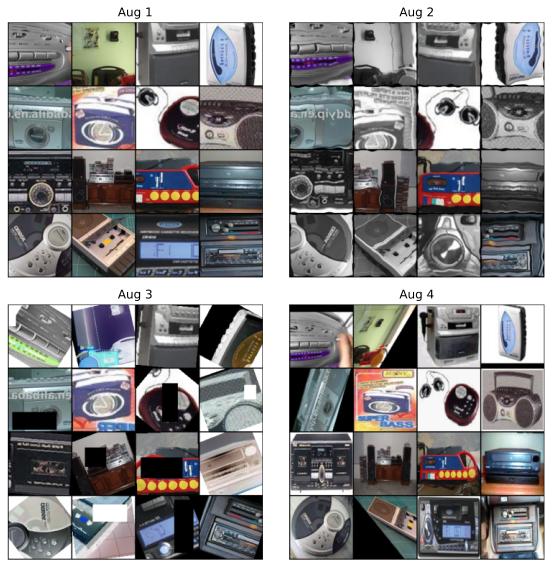

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))


for idx, (aug_name, transform) in enumerate(transforms_dict.items()):
    
    vis_dataset = ImageDataset(data_df=data_df, is_train=True, transform=transform)
    vis_dataloader = DataLoader(vis_dataset, batch_size=16, shuffle=False, num_workers=0)
    batch = next(iter(vis_dataloader))
    
    img_grid = torchvision.utils.make_grid(batch[0], nrow=4)
    
    ax[idx // 2, idx % 2].imshow(img_grid.permute(1, 2, 0).detach().cpu().numpy())
    ax[idx // 2, idx % 2].axis('off')
    ax[idx // 2, idx % 2].set_title(aug_name)

plt.tight_layout()
plt.show()

### `Подготовка данных к обучению`

Выберим минимальный набор аугментаций для нашей задаче. Наша цель не выбить выше качество, а написать хороший цикл обучения. Мы будем нормализировать изображения с помощью статистик, которые посчитали по всему `ImageNet`.

`IMG_MEAN[i]` содержит среднее значения пикселей для `i` канала.

`IMG_STD[i]` содержит стадартное отклонение пикселей для `i` канала.

In [14]:
IMG_MEAN = np.array([0.485, 0.456, 0.406])
IMG_STD  = np.array([0.229, 0.224, 0.225])

transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
        transforms.RandomCrop((160, 160)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.1),
        
    ]
)

transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=IMG_MEAN, std=IMG_STD),
        transforms.CenterCrop((160, 160))
    ]
)

**Вопрос:** Почему преобразования для `train` и `val` разные?

In [15]:
train_dataset = ImageDataset(data_df, is_train=True,  transform=transform_train)
valid_dataset = ImageDataset(data_df, is_train=False, transform=transform_val)

len(train_dataset), len(valid_dataset)

(9469, 3925)

In [16]:
vis_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
batch = next(iter(vis_dataloader))

print(f"Размерность батча: {batch[0].shape}")
print(f"Классы в батче: {batch[1]}")

Размерность батча: torch.Size([16, 3, 160, 160])
Классы в батче: tensor([8, 3, 0, 3, 7, 6, 6, 8, 2, 0, 8, 8, 9, 7, 1, 0])


Посмотрим на данные и как они выглядят после аугментаций. Иногда при **неправильных** аугментациях можно испортить изображение.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


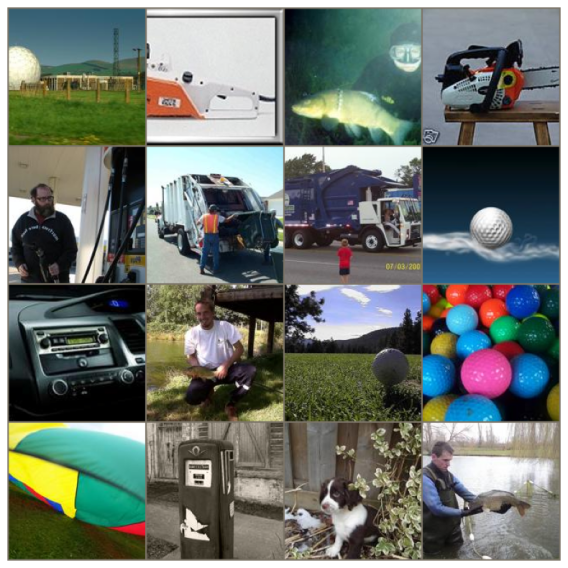

In [17]:
img_grid = torchvision.utils.make_grid(batch[0], nrow=4)

plt.figure(figsize=(8, 8))
plt.imshow(img_grid.permute(1, 2, 0).detach().cpu().numpy() * IMG_STD + IMG_MEAN)
plt.axis('off')

plt.tight_layout()
plt.show()

## `Train Loop`

Выше мы описали все необходимое для правильной и аккуратной работы с данных, а именно как получить `Dataloader` с изображениями и различными аугментациями. Благодаря этому мы можем не думать о работе с данными, а просто итерироаться по батчам.

Нам осталось определить:

- `нейронную сеть`, то что будет обучаться,

- `оптимизатор`, то как будет обучаться,

- `функцию потерь`, то по чему будем обучаться.

После этого мы сможем написать **цикл обучения**, в котором соединим все вместе.

### `LeNet для классификации`

[Le et al., 1998](https://ieeexplore.ieee.org/abstract/document/726791)

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
device = 'cpu'

if torch.cuda.is_available():
    device = 'cuda:0'
device

'cuda:0'

Мы будем использовать сверточные архитектуры, в частности реализуем что-то похожее на стандартную сеть `LeNet`. Мы могли бы начать с более сложных сетей, но у нас нет необходимости получить выше качество.

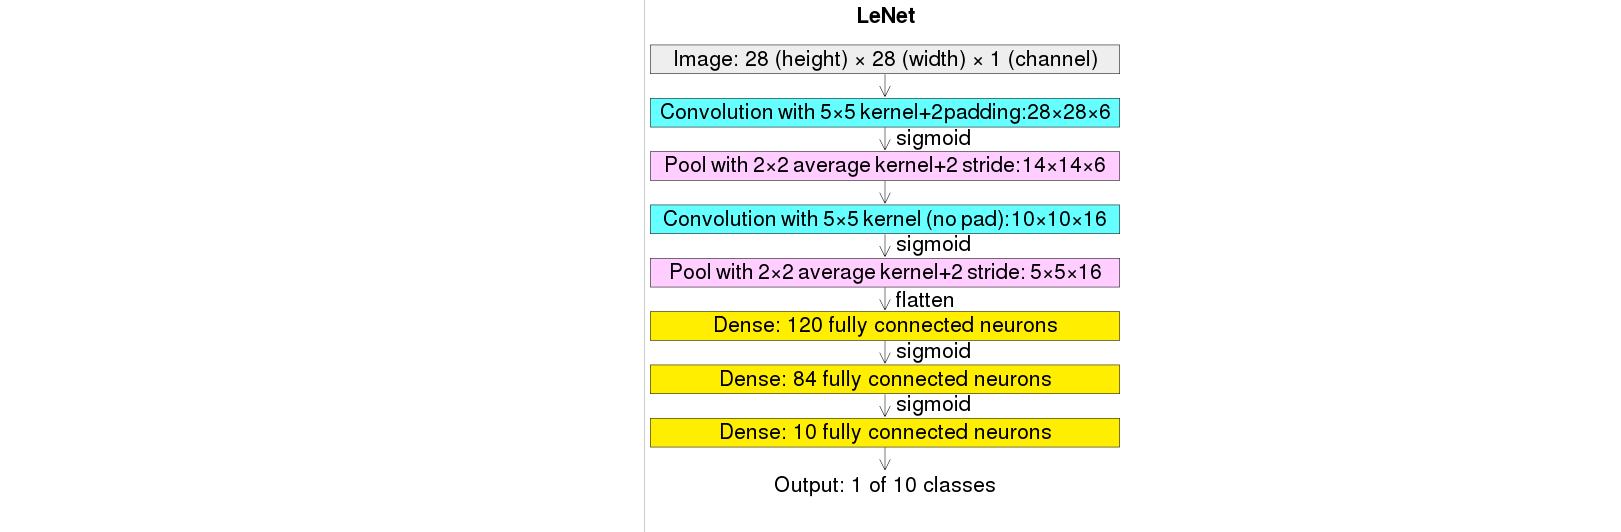

In [20]:
class LeNet(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=(5, 5)),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=(5, 5)),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.ReLU(),

            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5)),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
            torch.nn.ReLU(),
        )
        
        self.dense = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(16 * 16 * 16, 120),
            torch.nn.ReLU(),
            torch.nn.Linear(120, 84),
            torch.nn.ReLU(),
            torch.nn.Linear(84, n_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.dense(x)
        
        return x

Проверим, что мы не ошиблись в размерностях, самой первой проверкой является сделать forward для батча.

In [21]:
net = LeNet(n_classes=10)

batch = next(iter(vis_dataloader))
out = net(batch[0])

print(f"Размерность выхода: {out.shape}")

Размерность выхода: torch.Size([16, 10])


Посмотрим на число параметров, чтобы примерно оценить сложность модели.

In [22]:
def print_params_count(model):

    total_params = sum(p.numel() for p in model.parameters())
    total_params_grad = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    model_name = model.__class__.__name__
    print(f"Информация о числе параметров модели: {model_name}")
    print(f"Всего параметров: \t\t {total_params}")
    print(f"Всего обучаемых параметров: \t {total_params_grad}")
    print()

In [23]:
print_params_count(net)

Информация о числе параметров модели: LeNet
Всего параметров: 		 506432
Всего обучаемых параметров: 	 506432



В качестве оптимизатора возьмем `Adam`, который является стандартом области.

In [24]:
optimizer = optim.Adam(net.parameters(), lr=1e-4)

Так как мы решаем задачу классификации, то будем использовать `torch.nn.CrossEntropyLoss()`.

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()

In [26]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size  = 256, 
    shuffle     = True,
    drop_last   = True,
    num_workers = 0,
)

valid_dataloader = DataLoader(
    valid_dataset, 
    batch_size  = 4096, 
    shuffle     = False,
    num_workers = 0
)

Наконец-то мы можем написать **наш первый train loop**!

In [27]:
def train_base(epoch_num, net, optimizer, loss_fn, train_dataloader, device):
    
    ### YOUR CODE HERE
    
    global_step = 0
    net = net.to(device)
    net.train()
    
    for _ in tqdm(range(epoch_num)):
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            print(f"{global_step}, loss = {loss.item():0.3f}, \t accuracy = {accuracy.item():0.4f}")
            
            global_step += 1
            
        

In [28]:
# Обучим 1 эпоху, чтобы проверить корректность работы

epoch_num = 1
train_base(
    epoch_num        = epoch_num, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    device           = device
)

  0%|                                                               | 0/1 [00:00<?, ?it/s]

0, loss = 2.294, 	 accuracy = 0.1367
1, loss = 2.310, 	 accuracy = 0.1055
2, loss = 2.305, 	 accuracy = 0.1133
3, loss = 2.294, 	 accuracy = 0.1836
4, loss = 2.299, 	 accuracy = 0.1523
5, loss = 2.304, 	 accuracy = 0.1406
6, loss = 2.297, 	 accuracy = 0.1562
7, loss = 2.286, 	 accuracy = 0.1680
8, loss = 2.284, 	 accuracy = 0.1680
9, loss = 2.291, 	 accuracy = 0.1172
10, loss = 2.287, 	 accuracy = 0.1484
11, loss = 2.293, 	 accuracy = 0.1211
12, loss = 2.279, 	 accuracy = 0.1797
13, loss = 2.281, 	 accuracy = 0.1367
14, loss = 2.285, 	 accuracy = 0.1562
15, loss = 2.275, 	 accuracy = 0.1562
16, loss = 2.281, 	 accuracy = 0.1562
17, loss = 2.281, 	 accuracy = 0.1719
18, loss = 2.278, 	 accuracy = 0.1758
19, loss = 2.263, 	 accuracy = 0.1914
20, loss = 2.249, 	 accuracy = 0.1797
21, loss = 2.289, 	 accuracy = 0.1484
22, loss = 2.253, 	 accuracy = 0.1680
23, loss = 2.251, 	 accuracy = 0.1562
24, loss = 2.235, 	 accuracy = 0.2266
25, loss = 2.247, 	 accuracy = 0.1953
26, loss = 2.272, 	 ac

100%|███████████████████████████████████████████████████████| 1/1 [00:13<00:00, 13.99s/it]

35, loss = 2.221, 	 accuracy = 0.2188


Судя по выводу модель учится, качество растет, лосс падает. Правда, выглядит не совсем аккуратно и при тысячах итераций очень трудно понять что происходит с моделью.


**Вопрос**: Как исправить?

Для ответа на этот вопрос, мы воспользуемся библиотеками для логирования (`tensorboard`, `wandb`). В этом ноутбуки мы рассмотрим `wandb`.

### `wandb`

Официально с 12 сентября 2024 года, данная библиотека может не работать на территории РФ, но пока она всё ещё работает. 

Библиотеки для логирования созданы с целью простого отслеживания метрик и результатов экспериментов. Опишем основные функции `wandb` от очевидных до более неожаданных:

- Логирование чисел
- Логирование рисунков
- Логирование на удаленный сервер 
- Логироварние архитектуры
- Сохранение файлов
- Сохранение  состояний git
- Визуализация модели
- Построение графов гиперпараметров
- Автоматический поиск гиперепараметров и их визуализация

[Подробная документация](https://docs.wandb.ai/) может не работать без сторонних сервисов.

In [29]:
import wandb

При первой иницилизации попросить зарегистрироваться на сайте и указать API ключ, можно использовать аккаунт Google. Для логирования кода достаточно указать `save_code=True`.

In [30]:
# Иницилизация

wandb.init(
    project='testing_2025', 
    config={"conf": "testing"}, 
    save_code=True
)

wandb: Currently logged in as: 3145tttt. Use `wandb login --relogin` to force relogin


Для сохранения кода, достаточно прописать какие именно файлы в какой директории нужно сохранять. Для логирования используется функция `wandb.run.log_code`.

In [31]:
wandb.run.log_code(
    "./", 
    include_fn=lambda path: path.endswith(".ipynb")
)

In [32]:
# Логирование чисел
wandb.log({"train/loss": 0, "eval/loss": 0}, step=0)

**Важно:** Параметр `step` должен расти монотонно!

In [33]:
# Логирование изображений
wandb.log({"media/img": wandb.Image(img_grid)}, step=0)

In [34]:
# Логирование гистограм
wandb.log({"media/hist": wandb.Histogram(torch.arange(100) ** 2)}, step=0)

In [35]:
# Логирование графиков
fig = plt.figure(figsize=(6,6))
plt.plot(np.arange(100) ** 2)
plt.title(r"$y = x^2$")

wandb.log({"media/plots": wandb.Image(fig)}, step=0)

plt.close('all') # мы не хотим отображать графики в ноутбуке

Посмотрим на `run`, в нем должны отобразится логированные метрики. Иногда метрики логируются не сразу, а после заполнения некого буффера, так как синхронизация с веб затратная операция.

In [36]:
# Следующие шаги для визаулизаций
wandb.log({"train/loss": 2, "eval/loss": 1}, step=1)
wandb.log({"media/hist": wandb.Histogram(torch.arange(100) ** 3)}, step=1)


fig = plt.figure(figsize=(6,6))
plt.plot(np.arange(100) ** 3)
plt.title(r"$y = x^3$")

wandb.log({"media/plots": wandb.Image(fig)}, step=1)

# Сравнить в чем отличие
wandb.log({"media/img": wandb.Image(img_grid.permute(1, 2, 0).numpy() / 4 - 1)}, step=1)
wandb.log({"media/img": wandb.Image(img_grid / 4)}, step=2)


plt.close('all') # мы не хотим отображать графики в ноутбуке

In [37]:
wandb.finish()

In [38]:
def train_wandb(epoch_num, net, optimizer, loss_fn, train_dataloader, device, run_name):
    
    # ДОБАВИЛИ
    wandb.init(
        project="cnn_mmp_2025", 
        name=run_name,
        save_code=True
    )
    wandb.run.log_code(
        "./", 
        include_fn=lambda path: path.endswith(".ipynb")
    )
    
    global_step = 0
    net = net.to(device)
    
    for _ in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            # ДОБАВИЛИ
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
    
    # ДОБАВИЛИ
    wandb.finish()

**Вопрос:** Можно ли сразу запустить обучение? Например, сразу запустить код ниже.

In [39]:
# epoch_num = 1
# train_wandb(epoch_num, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device, run_name="LeNet_base")

In [40]:
net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [41]:
epoch_num = 10

train_wandb(
    epoch_num        = epoch_num, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader,
    device           = device, 
    run_name         = "LeNet_base"
)

100%|█████████████████████████████████████████████████████| 10/10 [01:52<00:00, 11.25s/it]


### **Вопрос:** Чего не хватает?

### `Валидация`

Обычно, модель выбирают по метрикам на валидационной выборке, кроме того, валидация хороший способ заметить переобучение.

In [42]:
@torch.no_grad()
def evaluate(net, valid_dataloader, loss_fn, device):
    
    ### YOUR CODE HERE
    
    net.eval()
    loss, accuracy = 0, 0
    count = 0
    for X_batch, y_true in valid_dataloader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        out = net(X_batch)
        y_pred = torch.argmax(out, 1)
        
        bs = out.shape[0]
        loss     += loss_fn(out, y_true).item() * bs
        accuracy += torch.sum(y_pred == y_true).item()
        count    += bs
        
    return loss / count, accuracy / count

    

def train_wandb_eval(epoch_num, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device, run_name):
    
    # ДОБАВИЛИ
    wandb.init(
        project="cnn_mmp_2025", 
        name=run_name,
        save_code=True
    )
    wandb.run.log_code(
        "./", 
        include_fn=lambda path: path.endswith(".ipynb")
    )
    
    global_step = 0
    net = net.to(device)
    
    for _ in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
        
        # ДОБАВИЛИ
        loss, accuracy = evaluate(
            net              = net, 
            valid_dataloader = valid_dataloader, 
            loss_fn          = loss_fn, 
            device           = device
            )
        wandb.log({"eval/loss": loss, "eval/accuracy": accuracy}, step=global_step)
        
    wandb.finish()

In [43]:
net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [44]:
epoch_num = 10
train_wandb_eval(
    epoch_num        = epoch_num, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device,
    run_name         = "LeNet_eval"
)

100%|█████████████████████████████████████████████████████| 10/10 [02:27<00:00, 14.77s/it]


### **Вопрос:** Чего не хватает?

### `Кризис воспроизводимости`

Выше мы могли заметить, что обучение сильно меняется от запуску к запуску, что создает следующие проблемы:

- Возможно, кто-то другой не сможет воспроизвести ваши результаты

- Возможно, **вы** никогда не сможете воспроизвести свои же результаты

Получить крутую модель, но без возможности повторения, крайне плохо для науки, бизнеса, домашней работы и просто грустно. Для воспроизводимых результатах не достаточно просто зафикисировать `seed`, пример ниже демонстрирует зависимость генератора случайных чисел от устройства.

In [45]:
torch.manual_seed(42) 
randn1 = torch.randn(10)

torch.manual_seed(42) 
randn2 = torch.randn(10)

randn1, randn2

(tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
          0.4617,  0.2674]),
 tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
          0.4617,  0.2674]))

In [46]:
torch.manual_seed(42) 
randn1 = torch.randn(10)

torch.manual_seed(42) 
randn2 = torch.randn(10, device='cuda')

randn1, randn2

(tensor([ 0.3367,  0.1288,  0.2345,  0.2303, -1.1229, -0.1863,  2.2082, -0.6380,
          0.4617,  0.2674]),
 tensor([ 0.1940,  2.1614, -0.1721,  0.8491, -1.9244,  0.6530, -0.6494, -0.8175,
          0.5280, -1.2753], device='cuda:0'))

Для начала постараемся сделать обучение независимым от очередности запуска, воспользуемся советами из официальной статьи [Reproducibilty PyTorch](https://pytorch.org/docs/stable/notes/randomness.html). Нам необходимо:

- Зафиксировать сид cpu
- Зафиксировать сид gpu
- Зафиксировать сид numpy
- Зафиксировать сид стандартного random

В целом этого уже будет достаточно и намного лучше, чем в большинстве современных работ. Малой кровью можно зафиксировать Dataloader, такое тоже будет полезно. Намного трудней использовать детерминированные алгоритмы `torch.use_deterministic_algorithms(True)`, так гарантируется точная воспроизводимость.

Мы действительно можем все зафиксировать, но возникает вопрос: "Будет ли хорошей модель, которая перестает учиться если чуть иначе зашафлить датасет или чуть иначе умножать матрицы?"

In [47]:
def set_global_seed(seed: int) -> None:
    """Set global seed for reproducibility.
    :param int seed: Seed to be set
    """
    

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    # если нужно гарантировать 1000% воспроизводимость
    # torch.use_deterministic_algorithms(False)

    # Для Dataloader
    g = torch.Generator()
    g.manual_seed(seed)
    
    return g

# Для каждого worker в Dataloader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


**Вопрос:** Где ошибка в коде ниже?

In [48]:
# net = LeNet(10)
# optimizer = optim.Adam(net.parameters(), lr=1e-4)

# g = set_global_seed(42)

# train_dataloader = DataLoader(
#     train_dataset, 
#     batch_size     = 256, 
#     shuffle        = True,
#     drop_last      = True,
#     num_workers    = 0, 
#     worker_init_fn = seed_worker, 
#     generator      = g
# )

# valid_dataloader = DataLoader(
#     valid_dataset,
#     batch_size    = 4096, 
#     shuffle       = False, 
#     num_workers   = 4
# )

# epoch_num = 10
# train_wandb_eval(
#     epoch_num       = epoch_num, 
#     net              = net, 
#     optimizer        = optimizer, 
#     loss_fn          = loss_fn, 
#     train_dataloader = train_dataloader, 
#     valid_dataloader = valid_dataloader, 
#     device           = device,
#     run_name         = "LeNet_seed"
# )

In [49]:
g = set_global_seed(42)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = 256, 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size    = 4096, 
    shuffle       = False, 
    num_workers   = 0
)

net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [50]:
epoch_num = 10
train_wandb_eval(
    epoch_num        = epoch_num, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device,
    run_name         = "LeNet_seed"
)

100%|█████████████████████████████████████████████████████| 10/10 [02:29<00:00, 14.91s/it]


### **Вопрос:** Чего не хватает?

### `Дополнительные логи`

Очень часто на практике обучение в какой-то момент просто ломается. Причины бывают разные и чем сложнее ваша модель и задача, тем более разные причины. Возможно, где то численная нестабильность, возможно засэмплировался странный батч. Для этого бывает полезно логировать **веса** и **градиенты** параметров.

Логирование градиентов также позволит отслеживать затухание или взрывы градиентов, что часто бывает полезно.

In [51]:
@torch.no_grad()
def log_gradients(model, global_step, log_norm=True, log_hist=True):
    for tag, value in model.named_parameters():
        g = value.grad
        if g is None:
            continue
        
        if log_hist:
            wandb.log({f"grad/{tag}": wandb.Histogram(g.cpu())}, global_step)
        
        if log_norm:
            wandb.log({f"grad_norm/{tag}": torch.norm(g.cpu())}, global_step)

@torch.no_grad()
def log_weights(model, global_step, log_norm=True, log_hist=True):
    for tag, value in model.named_parameters():
        g = value.grad
        if g is None:
            continue
        
        if log_hist:
            wandb.log({f"weight/{tag}": wandb.Histogram(value.cpu())}, global_step)
        
        if log_norm:
            wandb.log({f"weight_norm/{tag}": torch.norm(value.cpu())}, global_step)

In [52]:
def train_progress(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device):
    
    
    wandb.init(
        project="cnn_mmp_2025",
        name=config['name'], 
        config=config           # ДОБАВИЛИ 
    )
    wandb.run.log_code(
        "./", 
        include_fn=lambda path: path.endswith(".ipynb")
    )
    
    global_step = 0
    net = net.to(device)
    
    epoch_num = config['epoch_num']
    for _ in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            # ДОБАВИЛИ 
            log_gradients(net, global_step)
            log_weights(net, global_step)
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
        
        loss, accuracy = evaluate(
            net              = net, 
            valid_dataloader = valid_dataloader, 
            loss_fn          = loss_fn, 
            device           = device
            )
        wandb.log({"eval/loss": loss, "eval/accuracy": accuracy}, step=global_step)
        
    wandb.finish()


Выше мы добавили новые логи, но также хотелось бы запоминать гиперпараметры. Например, мы увидели, что какой-то запуск выбивает очень хорошие метрики, как вы будете воспроизводить этот запуск? Скорее всего на практике, вы забудете с какими параметрами вы запускали ваш код. Поэтому лучше сохранять все гиперпаметры внутри одного конфига. Так вы избавитесь и от магических констант и повысите воспроизводимость.

In [53]:
# ДОБАВИЛИ
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 4096,
    'name'           : 'LeNet_progress'
}

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size    = config['val_batch_size'], 
    shuffle       = False, 
    num_workers   = 0
)


net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [54]:
train_progress(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device
)

100%|█████████████████████████████████████████████████████| 10/10 [02:38<00:00, 15.85s/it]


### **Вопрос:** Чего не хватает?

### `Чекпоинты`

Обучение модели занимает много времени и ресурсов, но обычно модели учат не ради высокой метрики на валидации, а ради дальнейшего использования. Для того чтобы использовать модель в будущем, нужно явно прописать сохранения. Сохранять можно либо каждые `N` итераций, либо по метрике на валидации. Файл, в котором содержатся веса модели и иная важная информация об обучении называется **чекпоинтом** (точка сохранения).

- Обучить модель - хорошо.
- Обучить модель и получить воспроизводимые результаты - отлично
- Обучить модель и получить воспроизводимые результаты и сохранить веса - идеально

In [55]:
def train_final(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device):
    
    
    wandb.init(
        project="cnn_mmp_2025", 
        name=config['name'], 
        config=config
    )
    wandb.run.log_code(
        "./", 
        include_fn=lambda path: path.endswith(".ipynb")
    )
    
    global_step = 0
    net = net.to(device)
    
    # ДОБАВИЛИ
    best_accuracy = 0
    os.makedirs(config['checkpoint_dir'], exist_ok=True)
    
    epoch_num = config['epoch_num']
    for epoch in tqdm(range(epoch_num)):
        net.train()
        
        for X_batch, y_true in train_dataloader:
            optimizer.zero_grad()
            
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            
            out = net(X_batch)
            
            loss = loss_fn(out, y_true)
            loss.backward()
            
            optimizer.step()
            
            log_gradients(net, global_step)
            log_weights(net, global_step)
            
            y_pred = torch.argmax(out, 1)
            accuracy = torch.sum(y_pred == y_true) / y_pred.shape[0]
            
            wandb.log({"train/loss": loss.item(), "train/accuracy": accuracy.item()}, step=global_step)
            
            global_step += 1
        
        loss, accuracy = evaluate(
            net              = net, 
            valid_dataloader = valid_dataloader, 
            loss_fn          = loss_fn, 
            device           = device
        )
        wandb.log({"eval/loss": loss, "eval/accuracy": accuracy}, step=global_step)
        
        # ДОБАВИЛИ
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # YOUR CODE HERE
            torch.save({
                'epoch': epoch,
                'iter': global_step,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                'metric': accuracy
                }, os.path.join(config['checkpoint_dir'], config['checkpoint_name']))
        
    wandb.finish()

In [56]:
# ДОБАВИЛИ
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 4096,
    'name'           : 'LeNet_final',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'LeNet.pth'
}

g = set_global_seed(config['seed'])
g.manual_seed(0)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)


net = LeNet(10)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [57]:
train_final(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device
)

100%|█████████████████████████████████████████████████████| 10/10 [02:37<00:00, 15.79s/it]


### `Философия и немного рефлексии`

### **Вопрос:** Чего не хватает?

Как вы уже поняли отвечать на этот вопрос можно бесконечно, но давайте попробуем это сделать в последний раз за сегодня.

Циклы обучения отрадают то, что автор считает важным. Например, очень часто блок `.zero_grad()`, `.backward()`, `.step()` помещают внутрь отдельной функции. Иногда используют готовые фреймворки как:

- [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)

- [HuggingFace trainer](https://huggingface.co/docs/transformers/main_classes/trainer)

- [PyTorch Ignit](https://pytorch.org/ignite/index.html)

В них весь цикл обучения уже записан и вам достаточно просто передать функцию, которая по батчу считает ошибку.

**Почему же для такого простого цикл обучения, кто-то пишет отдельные библиотеки?**

Выше мы рассмотрели самую простую задачу без разных инженерных особенностей, на самом деле можно:

- Клипать градиенты
- Использовать смешанную точность
- Аккумулировать градиенты
- Использовать распределенное обучение
- Использовать экономию памяти GPU
- ...

Все это мы будем постепенно разбирать в будещем, пока мы научились самым основам, которые позоволят идти дальше.

**Важно:** Цикл обучение в исследовательских задачах это то, что делаете вы для себя и самое главное, чтобы вам было удобно. Кто-то пишет свои логгеры, а может вы найдете что-то свое.

Выше мы использовали подход обучения **эпохами**, но иногда бывает полезно обучать модели **итерациями**. Например, у нас нет конкретного обучающего датасета или же датасет слишком большой. В целом подход через итереции более универсальный и можно записать функцию `train` следующим образом:



```python
global_step = 0

for _ in tqdm(range(epoch)):
    for batch in data_loader:
        net.train()
        optim.zero_grad()
        
        loss = net(batch)
        loss.backward()
        
        optim.step()
        
        if global_step % config.eval_freq == 0:
            eval_loss = eval()
            
        if global_step % config.checkpoint_freq == 0:
            torch.save({'model': model.state_dict()}, 'checkpoint.pth')
            
        if global_step % config.whatever_freq == 0:
            ...
        
        if global_step == max_iter:
            return
        
        global_step += 1
```

#### `Результаты`

`LeNet` - очень простая архитектура. Если мы хотим получить хорошее качество, нужно использовать что-то посложнее (например, взять модель из `torchvision.models`), а также использовать аугментацию данных. Другой путь улучшения результата — использование предобученной сети и `transfer learning`.

Мы хотим повысить качество, но пока рассмотрели только самую базовую сверточную архитектуру. Прежде чем повысить качество, давайте попробуем получить некоторый `бейзлайн`, то с чем мы будем сравнивать результаты.

Сейчас у нас есть сверточный `бейзлайн` - `LeNet`

Ниже мы получим полносвязный `бейзлайн` - `MLP`

Дальше мы будем обучать `ResNet18`, у которого 11 миллионов параметров, поэтому у `MLP` должно быть сравнимое количество, иначе мы не сможем сделать по результатам сделать правильные выводы.

### `MLP`



In [58]:
class DeepNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super().__init__()
        
        self.fc_in = nn.Sequential(
                nn.Flatten(1),
                nn.Linear(in_features=input_dim, out_features=hidden_dims[0], bias=True), 
                nn.ReLU(),
            )
        
        self.layers = nn.Sequential(
            *[
                nn.Sequential(nn.Linear(h_in, h_out), nn.ReLU()) 
                for h_in, h_out in zip(hidden_dims[:-1], hidden_dims[1:])
             ],
        )
        
        self.fc_out = nn.Linear(hidden_dims[-1], num_classes)
    
    def forward(self, x):
        x = self.fc_in(x)
        x = self.layers(x)
        
        return self.fc_out(x)

In [59]:
print_params_count(LeNet(10))
print_params_count(DeepNetwork(input_dim=160 * 160 * 3, hidden_dims=[128, 256, 256, 128], num_classes=10))


Информация о числе параметров модели: LeNet
Всего параметров: 		 506432
Всего обучаемых параметров: 	 506432

Информация о числе параметров модели: DeepNetwork
Всего параметров: 		 9963530
Всего обучаемых параметров: 	 9963530



In [60]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 4096,
    'name'           : 'MLP',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'MLP.pth',
    'input_dim'      : 160 * 160 * 3,        # ДОБАВИЛИ
    'hidden_dims'    : [128, 256, 256, 128], # ДОБАВИЛИ
}
config['name'] = f"{config['name']}_{config['hidden_dims']}"

g = set_global_seed(config['seed'])
g.manual_seed(0)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size    = config['val_batch_size'], 
    shuffle       = False, 
    num_workers   = 0
)

net = DeepNetwork(
    input_dim   = config['input_dim'], 
    hidden_dims = config['hidden_dims'], 
    num_classes = 10
    )
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [61]:
train_final(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device
)

100%|█████████████████████████████████████████████████████| 10/10 [03:24<00:00, 20.44s/it]


## `Transfer learning`

**Чаще всего вы будете дообучать модели**, так как учить модель с нуля очень дорого, а воспроизвести SOTA результаты еще труднее. Ниже мы будем исследовать разные подходы к `transfer learning`, но нам нужно иметь какой-то стандарт, с которым мы будем сравниваться. Поэтому помимо `transfer learning` мы еще и обучим модель сами. 

Все эксперименты будем проводить с теми же параметрами обучения, что и раньше, чтобы мы могли ответить на вопрос: **"Как именно влияет архитектура?"**.

In [62]:
from torchvision.models import resnet18, ResNet18_Weights

In [63]:
net = resnet18()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Посмотрим на число параметров.

In [64]:
print_params_count(LeNet(10))
print_params_count(net)

Информация о числе параметров модели: LeNet
Всего параметров: 		 506432
Всего обучаемых параметров: 	 506432

Информация о числе параметров модели: ResNet
Всего параметров: 		 11689512
Всего обучаемых параметров: 	 11689512



Напишем класс обертку, чтобы было удобно работать с нейросетью. Кроме того, добавим параметры `mean` и `std`, так мы контроллировать, что подается нейросети на вход. 

**Вопрос:** Зачем может потребоваться добавление `mean` и `std`?

In [65]:
class ResNetWrapper(nn.Module):
    def __init__(self, resnet_model, mean=0., std=1.):
        super().__init__()
        
        self.resnet_block = resnet_model
        self.std = std
        self.mean = mean
        
    def forward(self, x):
        
        x = x * self.std + self.mean
        
        # Зачем может потребоваться интерполяция?
        # Почему в случае ResNet она не нужна?
        x = torch.nn.functional.interpolate(x, scale_factor=1)
        x = self.resnet_block(x)

        return x

Обучим модель "с нуля", то есть без предобученных весов и без замороженных параметров.

In [66]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 256,
    'name'           : 'ResNet18_train',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'ResNet.pth'
}

g = set_global_seed(config['seed'])
g.manual_seed(0)

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)

# Добавили
resnet_model = resnet18()
# Почему делаем так?
resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNetWrapper(resnet_model)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [67]:
train_final(
    config           = config, 
    net              = net, 
    optimizer        = optimizer, 
    loss_fn          = loss_fn, 
    train_dataloader = train_dataloader, 
    valid_dataloader = valid_dataloader, 
    device           = device
)

100%|█████████████████████████████████████████████████████| 10/10 [06:28<00:00, 38.88s/it]


### `Finetuning`

Воспользуемся теперь предообученной версией, которую учили на ImageNet с [разными лайфками](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/). Будем файтюнить модель обучая все ее веса. Существуют подходы с более аккуратной настройкой весов, например, с помощью заморозки **только некоторых** слоев.

In [68]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 256,
    'name'           : 'ResNet18_train_finetuning',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'ResNet_finetuning.pth'
}

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)

resnet_model = resnet18(
    weights=ResNet18_Weights.IMAGENET1K_V1 # Добавили
)
resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNetWrapper(resnet_model)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [69]:
train_final(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [06:08<00:00, 36.81s/it]


### `Linear probing`

При `linear probing` мы будем учить только линейный слой (голову нейронной сети).

In [70]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 256,
    'name'           : 'ResNet18_lp',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'ResNet_lp.pth'
}

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)

resnet_model = resnet18(
    weights=ResNet18_Weights.IMAGENET1K_V1
)

# Добавили
for parameter in resnet_model.parameters():
    parameter.requires_grad_(False)

# Почему тут?
resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNetWrapper(resnet_model)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [71]:
print_params_count(net)

Информация о числе параметров модели: ResNetWrapper
Всего параметров: 		 11181642
Всего обучаемых параметров: 	 5130



In [72]:
train_final(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [02:47<00:00, 16.79s/it]


### `Out-of domain`

Мы хотим понять, как работают предобученные веса, на данных вне обучаемого домена. Например если мы учились на днных с `mean=0`, а в нашем датасете данные с `mean=1`. Например, мы учились на изображениях кошек, но хотим использовать веса для обучения на изображениях собак.

Менять датасет мы не будем, просто добавим поменяем `mean` и `std` в обертке.

In [73]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 256,
    'name'           : 'ResNet18_train_finetuning_ood',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'ResNet_finetuning.pth'
}

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)

resnet_model = resnet18(
    weights=ResNet18_Weights.IMAGENET1K_V1
)
resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNetWrapper(
    resnet_model,
    mean = 4,   # Добавили
    std  = 0.1  # Добавили
)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [74]:
train_final(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [06:06<00:00, 36.65s/it]


In [75]:
config = {
    'seed'           : 42, 
    'lr'             : 1e-4, 
    'epoch_num'      : 10, 
    'batch_size'     : 256, 
    'val_batch_size' : 256,
    'name'           : 'ResNet18_lp_ood',
    'checkpoint_dir' : './checkpoints', 
    'checkpoint_name': 'ResNet_lp.pth'
}

g = set_global_seed(config['seed'])

train_dataloader = DataLoader(
    train_dataset, 
    batch_size     = config['batch_size'], 
    shuffle        = True,
    drop_last      = True,
    num_workers    = 0, 
    worker_init_fn = seed_worker, 
    generator      = g
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size   = config['val_batch_size'], 
    shuffle      = False, 
    num_workers  = 0
)

resnet_model = resnet18(
    weights=ResNet18_Weights.IMAGENET1K_V1
)

for parameter in resnet_model.parameters():
    parameter.requires_grad_(False)


resnet_model.fc = torch.nn.Linear(512, 10) 

net = ResNetWrapper(
    resnet_model,
    mean = 4,   # Добавили
    std  = 0.1  # Добавили
)
optimizer = optim.Adam(net.parameters(), lr=config['lr'])

In [76]:
train_final(config, net, optimizer, loss_fn, train_dataloader, valid_dataloader, device)

100%|█████████████████████████████████████████████████████| 10/10 [02:48<00:00, 16.87s/it]


## `Конфиги`

Существуют аккуратные способы управления конфигами, например использование `ml_collection.Config_Dict` или же библиотеки `Hydra`. Ниже разбирем примеры конфигов из реальных работ.

In [77]:
import ml_collections

In [78]:
# пример взят https://github.com/yang-song/score_sde_pytorch/blob/cb1f359f4aadf0ff9a5e122fe8fffc9451fd6e44/configs/default_cifar10_configs.py#L5

def get_default_configs():
    config = ml_collections.ConfigDict()
    # training
    config.training = training = ml_collections.ConfigDict()
    config.training.batch_size = 128
    training.n_iters = 1300001
    training.snapshot_freq = 50000
    training.log_freq = 50
    training.eval_freq = 100
    ## store additional checkpoints for preemption in cloud computing environments
    training.snapshot_freq_for_preemption = 10000
    ## produce samples at each snapshot.
    training.snapshot_sampling = True
    training.likelihood_weighting = False
    training.continuous = True
    training.reduce_mean = False

    # evaluation
    config.eval = evaluate = ml_collections.ConfigDict()
    evaluate.begin_ckpt = 9
    evaluate.end_ckpt = 26
    evaluate.batch_size = 1024
    evaluate.enable_sampling = False
    evaluate.num_samples = 50000
    evaluate.enable_loss = True
    evaluate.enable_bpd = False
    evaluate.bpd_dataset = 'test'

    # data
    config.data = data = ml_collections.ConfigDict()
    data.dataset = 'CIFAR10'
    data.image_size = 32
    data.random_flip = True
    data.centered = False
    data.uniform_dequantization = False
    data.num_channels = 3

    # model
    config.model = model = ml_collections.ConfigDict()
    model.sigma_min = 0.01
    model.sigma_max = 50
    model.num_scales = 1000
    model.beta_min = 0.1
    model.beta_max = 20.
    model.dropout = 0.1
    model.embedding_type = 'fourier'

    # optimization
    config.optim = optim = ml_collections.ConfigDict()
    optim.weight_decay = 0
    optim.optimizer = 'Adam'
    optim.lr = 2e-4
    optim.beta1 = 0.9
    optim.eps = 1e-8
    optim.warmup = 5000
    optim.grad_clip = 1.

    config.seed = 42
    config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    return config

get_default_configs()

data:
  centered: false
  dataset: CIFAR10
  image_size: 32
  num_channels: 3
  random_flip: true
  uniform_dequantization: false
device: !!python/object/apply:torch.device
- cuda
- 0
eval:
  batch_size: 1024
  begin_ckpt: 9
  bpd_dataset: test
  enable_bpd: false
  enable_loss: true
  enable_sampling: false
  end_ckpt: 26
  num_samples: 50000
model:
  beta_max: 20.0
  beta_min: 0.1
  dropout: 0.1
  embedding_type: fourier
  num_scales: 1000
  sigma_max: 50
  sigma_min: 0.01
optim:
  beta1: 0.9
  eps: 1.0e-08
  grad_clip: 1.0
  lr: 0.0002
  optimizer: Adam
  warmup: 5000
  weight_decay: 0
seed: 42
training:
  batch_size: 128
  continuous: true
  eval_freq: 100
  likelihood_weighting: false
  log_freq: 50
  n_iters: 1300001
  reduce_mean: false
  snapshot_freq: 50000
  snapshot_freq_for_preemption: 10000
  snapshot_sampling: true

In [79]:
from hydra import compose, initialize
from omegaconf import OmegaConf

In [80]:
# Пример взят по ссылке
# https://github.com/CompVis/latent-diffusion/blob/a506df5756472e2ebaf9078affdde2c4f1502cd4/configs/autoencoder/autoencoder_kl_32x32x4.yaml#L1

!cat ./hydra_example.yaml

model:
  base_learning_rate: 4.5e-6
  target: ldm.models.autoencoder.AutoencoderKL
  params:
    monitor: "val/rec_loss"
    embed_dim: 4
    lossconfig:
      target: ldm.modules.losses.LPIPSWithDiscriminator
      params:
        disc_start: 50001
        kl_weight: 0.000001
        disc_weight: 0.5

    ddconfig:
      double_z: True
      z_channels: 4
      resolution: 256
      in_channels: 3
      out_ch: 3
      ch: 128
      ch_mult: [ 1,2,4,4 ]  # num_down = len(ch_mult)-1
      num_res_blocks: 2
      attn_resolutions: [ ]
      dropout: 0.0

data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 12
    wrap: True
    train:
      target: ldm.data.imagenet.ImageNetSRTrain
      params:
        size: 256
        degradation: pil_nearest
    validation:
      target: ldm.data.imagenet.ImageNetSRValidation
      params:
        size: 256
        degradation: pil_nearest

lightning:
  callbacks:
    image_logger:
      target: main.ImageLogger
      params:
        

In [81]:
with initialize(config_path='./', version_base=None):
    config = compose(config_name="hydra_example.yaml")
    
config

{'model': {'base_learning_rate': 4.5e-06, 'target': 'ldm.models.autoencoder.AutoencoderKL', 'params': {'monitor': 'val/rec_loss', 'embed_dim': 4, 'lossconfig': {'target': 'ldm.modules.losses.LPIPSWithDiscriminator', 'params': {'disc_start': 50001, 'kl_weight': 1e-06, 'disc_weight': 0.5}}, 'ddconfig': {'double_z': True, 'z_channels': 4, 'resolution': 256, 'in_channels': 3, 'out_ch': 3, 'ch': 128, 'ch_mult': [1, 2, 4, 4], 'num_res_blocks': 2, 'attn_resolutions': [], 'dropout': 0.0}}}, 'data': {'target': 'main.DataModuleFromConfig', 'params': {'batch_size': 12, 'wrap': True, 'train': {'target': 'ldm.data.imagenet.ImageNetSRTrain', 'params': {'size': 256, 'degradation': 'pil_nearest'}}, 'validation': {'target': 'ldm.data.imagenet.ImageNetSRValidation', 'params': {'size': 256, 'degradation': 'pil_nearest'}}}}, 'lightning': {'callbacks': {'image_logger': {'target': 'main.ImageLogger', 'params': {'batch_frequency': 1000, 'max_images': 8, 'increase_log_steps': True}}}, 'trainer': {'benchmark':